In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow import keras
from numpy import array

In [7]:
#######################################################
############### If using Google Drive #################
#######################################################

# Please note that if this cell does not run go to where the shared folder is on Google Drive, and
# right-click on the shared folder, and select Add shortcut to Drive. Then try execute the cell again.

# Mount Google Drive where datasets are located
from google.colab import drive
drive.mount('/content/gdrive')

# Change the current working directory
%cd /content/gdrive/MyDrive/DS\ Capstone\ Project/REPORT_CODE_STRUCTURED/

# Define data paths
data_path1 = "data/LSTM/"
data_path2 = "data/original/"
data_path3 = "keras_saved_models/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/107U69c8Nh3fH_vc0lG1KAZi0i92sHvcb/DS Capstone Project/REPORT_CODE_STRUCTURED


In [ ]:
#######################################################
############### If using Local Computer ###############
#######################################################

# Define data paths
data_path1 = "../data/LSTM/"
data_path2 = "../data/original/"
data_path3 = "../keras_saved_models/"

In [8]:
# Read in testing data to reproduce final model results
X_test = np.load(f'{data_path1}testing_data_for_LSTM.npy')
X_test_tf = tf.convert_to_tensor(X_test, np.float32) 

# Read in data to append test preds to
df = pd.read_csv(f'{data_path1}data_to_append_test_preds.csv')

# Read QLD predispatch data in to compare to test preds
df_qld_fc = pd.read_csv(f'{data_path2}forecastdemand_qld.csv')

# Load most accurate saved model
model = keras.models.load_model(f"{data_path3}Keras_model_epochs_20")
# model = keras.models.load_model("../keras_saved_models/Keras_model_epochs_10")
# model = keras.models.load_model("../keras_saved_models/Keras_model_epochs_15")
# model = keras.models.load_model("../keras_saved_models/Keras_model_epochs_25")

In [ ]:
# Scales predictions back to original scale
scale_min = np.array([4173.36, 4173.36, 4173.36, 4173.36, 4173.36, 4173.36])
scale_max = np.array([9988.09, 9988.09, 9988.09, 9988.09, 9988.09, 9988.09])

def inv_transform(df, min_=scale_min, max_=scale_max):
  for i in range(len(min_)):
    df[:, i] = df[:, i] * (max_[i] - min_[i]) + min_[i]
  return df

In [ ]:
# Calculates the residuals
def residuals(df, max=6*30+30):
  for i in range(30, max, 30):
    df[f'residuals_{i}'] = df[f'plus_{i}'] - df[f'pred_{i}']
  return df

In [ ]:
# Get train and test predictions
preds_test = model.predict(X_test_tf)

# Get cols
colsPred = ['DATETIME', 'TOTALDEMAND'] + [f'plus_{x}' for x in range(30, 7*30, 30)]

# Adding DATETIME to testing predictions
len_train_preds = 69553
n_steps_in=48

test_preds = df[colsPred][len_train_preds+n_steps_in-1:].copy()
test_preds[[f'pred_{x}' for x in range(30, 7*30, 30)]] = inv_transform(preds_test)
test_preds = residuals(test_preds)

# Residuals / plus (for MAPE)
for i in range(30, 7*30, 30):
  test_preds[f'resid_over_actual_{i}'] = test_preds[f'residuals_{i}'] / test_preds[f'plus_{i}']

In [ ]:
# Create functions to calculate RMSE, MSE, MAE, MAPE, R-Squared
def RMSE(dfPreds, cols=[f'residuals_{x}' for x in range(30, 30*6+30, 30)]):
  RMSE = dfPreds[cols].apply(lambda x: x**2, axis=1).agg('mean').apply(lambda x: np.sqrt(x)).mean()
  return RMSE

def MSE(dfPreds, cols=[f'residuals_{x}' for x in range(30, 30*6+30, 30)]):
  MSE = dfPreds[cols].apply(lambda x: x**2, axis=1).agg('mean').mean()
  return MSE

def MAE(dfPreds, cols=[f'residuals_{x}' for x in range(30, 30*6+30, 30)]):
  MAE = dfPreds[cols].apply(lambda x: np.abs(x), axis=1).agg('mean').mean()
  return MAE

def MAPE(dfPreds, cols=[f'resid_over_actual_{x}' for x in range(30, 30*6+30, 30)]):
  MAPE = dfPreds[cols].apply(lambda x: np.abs(x), axis=1).agg('mean').mean()
  return MAPE

def Rsq(df, 
        cols=[f'residuals_{x}' for x in range(30, 30*6+30, 30)],
        cols2=[f'plus_{x}' for x in range(30, 30*6+30, 30)]):
  MSE = df[cols].apply(lambda x: x**2, axis=1).agg('mean').mean()
  VAR = df[cols2].apply(lambda x: np.var(x)).mean()
  R_Squared = 1 - (MSE / VAR)
  return R_Squared

RMSE = RMSE(test_preds)
MSE = MSE(test_preds)
MAE = MAE(test_preds)
MAPE = MAPE(test_preds)
R_Squared = Rsq(test_preds)

In [ ]:
print(f'RMSE: {RMSE}\n'
      f'MSE: {MSE}\n'
      f'MAE: {MAE}\n'
      f'MAPE: {MAPE}\n'
      f'Accuracy: {1 - MAPE}\n'
      f'R Squared: {R_Squared}')

RMSE: 200.69174755687126
MSE: 42740.266755833574
MAE: 153.3699464820247
MAPE: 0.025264238974862036
Accuracy: 0.9747357610251379
R Squared: 0.9531286607535238


# Visualisation

In [ ]:
# Make a copy of the DataFrame for visualisation
ddf = test_preds.reset_index(drop=True).copy()

# Inpsect DataFrame
ddf.head(5)

,DATETIME,TOTALDEMAND,plus_30,plus_60,plus_90,plus_120,plus_150,plus_180,pred_30,pred_60,pred_90,pred_120,pred_150,pred_180,residuals_30,residuals_60,residuals_90,residuals_120,residuals_150,residuals_180,resid_over_actual_30,resid_over_actual_60,resid_over_actual_90,resid_over_actual_120,resid_over_actual_150,resid_over_actual_180
0,2020-01-01 00:00:00,6218.39,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,6122.640137,5987.411621,5925.178223,5897.328125,5892.479004,5846.409668,-93.280137,-33.091621,-36.498223,-76.698125,-141.819004,-140.579668,-0.015471,-0.005558,-0.006198,-0.013177,-0.024661,-0.024638
1,2020-01-01 00:30:00,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,6044.562500,5938.338379,5906.976562,5909.104492,5928.579102,5925.958496,-90.242500,-49.658379,-86.346562,-158.444492,-222.749102,-263.788496,-0.015156,-0.008433,-0.014835,-0.027552,-0.039039,-0.046588
2,2020-01-01 01:00:00,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,5970.916992,5890.720215,5883.845703,5911.102051,5947.496094,6002.677734,-82.236992,-70.090215,-133.185703,-205.272051,-285.326094,-409.527734,-0.013965,-0.012042,-0.023160,-0.035976,-0.050392,-0.073220
3,2020-01-01 01:30:00,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,5919.607910,5863.543457,5877.820801,5926.349609,5985.188477,6096.514648,-98.977910,-112.883457,-171.990801,-264.179609,-392.038477,-516.374648,-0.017005,-0.019630,-0.030143,-0.046657,-0.070093,-0.092538
4,2020-01-01 02:00:00,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,5570.90,5878.236328,5847.460449,5882.394043,5956.287109,6046.595703,6208.661133,-127.576328,-141.630449,-220.224043,-363.137109,-466.455703,-637.761133,-0.022185,-0.024822,-0.038894,-0.064925,-0.083592,-0.114481


In [ ]:
# Create function that reformats data into a form ready for visualising
def plot_ready_preds(df, start_time='2020-01-01 00:00:00'):
  index_start_time = df[df['DATETIME'] == start_time].index
  time = pd.date_range(start_time, periods=7, freq='30T')
  actual = list(df.loc[index_start_time, ['TOTALDEMAND'] + [f'plus_{x}' for x in range(30, 30*6+30, 30)]].squeeze())
  pred = list(df.loc[index_start_time, ['TOTALDEMAND'] + [f'pred_{x}' for x in range(30, 30*6+30, 30)]].squeeze())
  pred[0] = np.nan

  pdf = pd.DataFrame(data = {
      'DATETIME': time,
      'ACTUAL': actual,
      'PREDICTION': pred,
  })

  return pd.melt(pdf, id_vars=['DATETIME'], value_vars=['ACTUAL', 'PREDICTION'])

x = plot_ready_preds(ddf)
x

,DATETIME,variable,value
0,2020-01-01 00:00:00,ACTUAL,6218.390000
1,2020-01-01 00:30:00,ACTUAL,6029.360000
2,2020-01-01 01:00:00,ACTUAL,5954.320000
3,2020-01-01 01:30:00,ACTUAL,5888.680000
4,2020-01-01 02:00:00,ACTUAL,5820.630000
5,2020-01-01 02:30:00,ACTUAL,5750.660000
6,2020-01-01 03:00:00,ACTUAL,5705.830000
7,2020-01-01 00:00:00,PREDICTION,NaN
8,2020-01-01 00:30:00,PREDICTION,6122.640137
9,2020-01-01 01:00:00,PREDICTION,5987.411621


In [ ]:
# Create function that reformats data into a form ready for visualising
def td_fc(df_td, df_fc, predis=2020010101):
  df_pre = df_fc[df_fc['PREDISPATCHSEQNO'] == predis].reset_index(drop=True)
  
  # Get first row and replace values
  first_row = df_pre.head(1).copy()
  dt_less_30 = str(pd.to_datetime(first_row['DATETIME'][0])+ pd.Timedelta('-30min'))

  first_row['PERIODID'] = 0
  first_row['FORECASTDEMAND'] = np.nan #float(df_td[df_td['DATETIME'] == dt_less_30]['TOTALDEMAND'])
  first_row['DATETIME'] = dt_less_30

  # Append row to start of df_pre
  df = pd.concat([first_row, df_pre]).reset_index(drop=True)

  # Let's get actuals and predictions to join
  index_start_time = df_td[df_td['DATETIME'] == first_row['DATETIME'][0]].index
  datetime = list(pd.date_range(first_row['DATETIME'][0], periods=7, freq='30T'))
  actual = list(df_td.loc[index_start_time, ['TOTALDEMAND'] + [f'plus_{x}' for x in range(30, 30*6+30, 30)]].squeeze())
  pred = list(df_td.loc[index_start_time, ['TOTALDEMAND'] + [f'pred_{x}' for x in range(30, 30*6+30, 30)]].squeeze())
  pred[0] = np.nan

  pdf = pd.DataFrame(data = {
      'DATETIME': [str(x) for x in datetime],
      'ACTUAL': actual,
      'PREDICTION': pred,
  })

  joined = df.merge(pdf, on='DATETIME', how='left').dropna(subset=['ACTUAL'])
  joined = pd.melt(joined, id_vars=['DATETIME', 'LASTCHANGED'], value_vars=['ACTUAL', 'PREDICTION', 'FORECASTDEMAND'])
  joined['DATETIME'] = pd.to_datetime(joined['DATETIME'], format='%Y-%m-%d %H:%M:%S').dt.strftime('%-H:%M')
  return joined

plotME1 = td_fc(ddf, df_qld_fc, predis=2020010101)
plotME2 = td_fc(ddf, df_qld_fc, predis=2020010201)
plotME3 = td_fc(ddf, df_qld_fc, predis=2020010301)
plotME4 = td_fc(ddf, df_qld_fc, predis=2020010401)
plotME = [plotME1, plotME2, plotME3, plotME4]

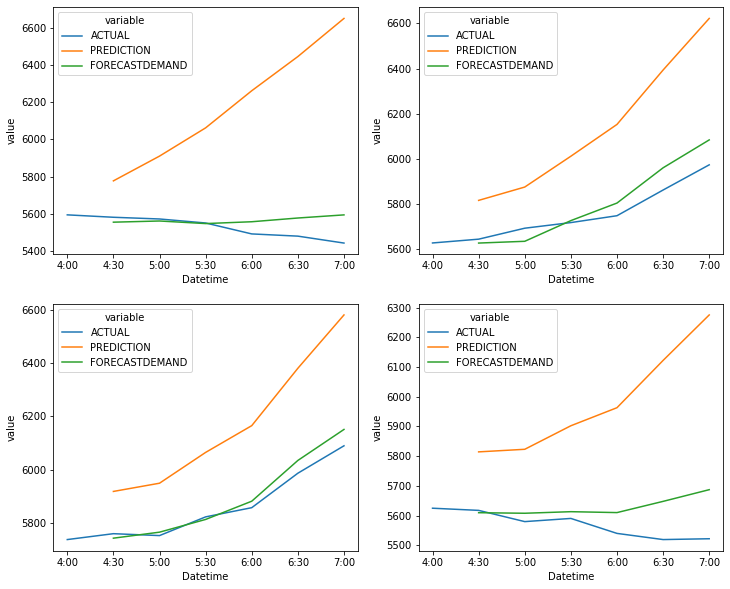

In [ ]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
  sns.lineplot(data=plotME[i], x='DATETIME', y='value', hue='variable', ax=ax)
  ax.set(xlabel='Datetime')

# Calculate metrics between FORECASTDEMAND and TOTALDEMAND for 3 hours

In [ ]:
# Compare FORECASTDEMAND feature is forecast dataset to TOTALDEMAND in total demand dataset
condition = (df_qld_fc['PREDISPATCHSEQNO'] >= 2019123140) & (df_qld_fc['PREDISPATCHSEQNO'] <= 2021031735) & (df_qld_fc['PERIODID'] <= 6)
df_qld_fc2 = df_qld_fc[condition].copy()

In [ ]:
# Convert DATETIME to datetime64[ns] object
df_qld_fc2['DATETIME'] = pd.to_datetime(df_qld_fc2['DATETIME'], format='%Y-%m-%d %H:%M:%S')

# Let's add a new column, and subtract 30mins from DATETIME, to join with tdTemp data
df_qld_fc2['LASTCHANGED'] = df_qld_fc2['DATETIME'] + pd.Timedelta(minutes=-30)

# Make DATETIME_less_30 same for each PREDISPATCHSEQNO
for periodid in range(2, 7):
  df_qld_fc2.loc[df_qld_fc2['PERIODID'] == periodid, 'LASTCHANGED'] = df_qld_fc2.loc[df_qld_fc2['PERIODID'] == periodid, 'LASTCHANGED'] + pd.Timedelta(minutes=-30*(periodid-1))

# Drop unnecessary features
df_qld_fc2.drop(columns=['PREDISPATCHSEQNO', 'REGIONID'], inplace=True)

In [ ]:
df_qld_fc2.head(5)

,PERIODID,FORECASTDEMAND,LASTCHANGED,DATETIME
2918120,1,6251.37,2019-12-31 23:30:00,2020-01-01 00:00:00
2918121,2,6067.02,2019-12-31 23:30:00,2020-01-01 00:30:00
2918122,3,5968.33,2019-12-31 23:30:00,2020-01-01 01:00:00
2918123,4,5878.84,2019-12-31 23:30:00,2020-01-01 01:30:00
2918124,5,5794.75,2019-12-31 23:30:00,2020-01-01 02:00:00


In [ ]:
# Pivoting data
df_qld_fc3 = pd.pivot_table(df_qld_fc2, values='FORECASTDEMAND', index=['LASTCHANGED'], columns=['PERIODID']).reset_index()

# Renaming columns
df_qld_fc3.rename(columns={1: "fc_30", 2: "fc_60", 3: "fc_90", 4: "fc_120", 5: "fc_150", 6: "fc_180"}, inplace=True)

In [ ]:
df_qld_fc3

PERIODID,LASTCHANGED,fc_30,fc_60,fc_90,fc_120,fc_150,fc_180
0,2019-12-31 23:30:00,6251.37,6067.02,5968.33,5878.84,5794.75,5719.94
1,2020-01-01 00:00:00,6067.77,5961.27,5875.92,5797.70,5725.73,5663.38
2,2020-01-01 00:30:00,5954.34,5853.29,5772.43,5704.40,5645.11,5601.27
3,2020-01-01 01:00:00,5893.00,5807.80,5740.93,5688.37,5643.50,5595.46
4,2020-01-01 01:30:00,5830.57,5746.36,5693.93,5653.89,5607.97,5583.06
...,...,...,...,...,...,...,...
21206,2021-03-17 19:00:00,7306.06,7184.47,7064.28,6873.53,6696.02,6531.97
21207,2021-03-17 19:30:00,7206.47,7057.51,6839.54,6660.05,6496.96,6362.63
21208,2021-03-17 20:00:00,7070.18,6866.22,6693.69,6529.87,6390.98,6261.29
21209,2021-03-17 20:30:00,6889.29,6708.17,6540.50,6396.52,6264.42,6077.42


In [ ]:
# Let's make a copy of ddf
ddf2 = ddf.copy()

In [ ]:
# Need to convert 2 DataFrames datetimes to string type
df_qld_fc3['LASTCHANGED'] = df_qld_fc3['LASTCHANGED'].astype('str')
ddf2['DATETIME'] = ddf2['DATETIME'].astype('str')

# Inner join df_qld_fc3 and ddf2 by LASTCHANGED and DATETIME features 
df_joined = ddf2.merge(df_qld_fc3, left_on='DATETIME', right_on='LASTCHANGED', how='inner')

In [ ]:
df_joined.head()

,DATETIME,TOTALDEMAND,plus_30,plus_60,plus_90,plus_120,plus_150,plus_180,pred_30,pred_60,pred_90,pred_120,pred_150,pred_180,residuals_30,residuals_60,residuals_90,residuals_120,residuals_150,residuals_180,resid_over_actual_30,resid_over_actual_60,resid_over_actual_90,resid_over_actual_120,resid_over_actual_150,resid_over_actual_180,LASTCHANGED,fc_30,fc_60,fc_90,fc_120,fc_150,fc_180
0,2020-01-01 00:00:00,6218.39,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,6122.640137,5987.411621,5925.178223,5897.328125,5892.479004,5846.409668,-93.280137,-33.091621,-36.498223,-76.698125,-141.819004,-140.579668,-0.015471,-0.005558,-0.006198,-0.013177,-0.024661,-0.024638,2020-01-01 00:00:00,6067.77,5961.27,5875.92,5797.70,5725.73,5663.38
1,2020-01-01 00:30:00,6029.36,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,6044.562500,5938.338379,5906.976562,5909.104492,5928.579102,5925.958496,-90.242500,-49.658379,-86.346562,-158.444492,-222.749102,-263.788496,-0.015156,-0.008433,-0.014835,-0.027552,-0.039039,-0.046588,2020-01-01 00:30:00,5954.34,5853.29,5772.43,5704.40,5645.11,5601.27
2,2020-01-01 01:00:00,5954.32,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,5970.916992,5890.720215,5883.845703,5911.102051,5947.496094,6002.677734,-82.236992,-70.090215,-133.185703,-205.272051,-285.326094,-409.527734,-0.013965,-0.012042,-0.023160,-0.035976,-0.050392,-0.073220,2020-01-01 01:00:00,5893.00,5807.80,5740.93,5688.37,5643.50,5595.46
3,2020-01-01 01:30:00,5888.68,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,5919.607910,5863.543457,5877.820801,5926.349609,5985.188477,6096.514648,-98.977910,-112.883457,-171.990801,-264.179609,-392.038477,-516.374648,-0.017005,-0.019630,-0.030143,-0.046657,-0.070093,-0.092538,2020-01-01 01:30:00,5830.57,5746.36,5693.93,5653.89,5607.97,5583.06
4,2020-01-01 02:00:00,5820.63,5750.66,5705.83,5662.17,5593.15,5580.14,5570.90,5878.236328,5847.460449,5882.394043,5956.287109,6046.595703,6208.661133,-127.576328,-141.630449,-220.224043,-363.137109,-466.455703,-637.761133,-0.022185,-0.024822,-0.038894,-0.064925,-0.083592,-0.114481,2020-01-01 02:00:00,5734.35,5680.96,5654.09,5614.84,5591.89,5567.04


In [ ]:
# Calculates the residuals
def residuals_fc(df, max=6*30+30):
  for i in range(30, max, 30):
    df[f'residuals_fc_{i}'] = df[f'plus_{i}'] - df[f'fc_{i}']
  return df

In [ ]:
# Appending residuals
df_joined = residuals_fc(df_joined)

# Residuals / plus (for MAPE)
for i in range(30, 7*30, 30):
  df_joined[f'resid_over_actual_fc_{i}'] = df_joined[f'residuals_fc_{i}'] / df_joined[f'plus_{i}']

In [ ]:
# Create functions to calculate RMSE, MSE, MAE, MAPE, R-Squared
def RMSE(dfPreds, cols=[f'residuals_fc_{x}' for x in range(30, 30*6+30, 30)]):
  RMSE = dfPreds[cols].apply(lambda x: x**2, axis=1).agg('mean').apply(lambda x: np.sqrt(x)).mean()
  return RMSE

def MSE(dfPreds, cols=[f'residuals_fc_{x}' for x in range(30, 30*6+30, 30)]):
  MSE = dfPreds[cols].apply(lambda x: x**2, axis=1).agg('mean').mean()
  return MSE

def MAE(dfPreds, cols=[f'residuals_fc_{x}' for x in range(30, 30*6+30, 30)]):
  MAE = dfPreds[cols].apply(lambda x: np.abs(x), axis=1).agg('mean').mean()
  return MAE

def MAPE(dfPreds, cols=[f'resid_over_actual_{x}' for x in range(30, 30*6+30, 30)]):
  MAPE = dfPreds[cols].apply(lambda x: np.abs(x), axis=1).agg('mean').mean()
  return MAPE

def Rsq(df, 
        cols=[f'residuals_fc_{x}' for x in range(30, 30*6+30, 30)],
        cols2=[f'plus_{x}' for x in range(30, 30*6+30, 30)]):
  MSE = df[cols].apply(lambda x: x**2, axis=1).agg('mean').mean()
  VAR = df[cols2].apply(lambda x: np.var(x)).mean()
  R_Squared = 1 - (MSE / VAR)
  return R_Squared

RMSE = RMSE(df_joined)
MSE = MSE(df_joined)
MAE = MAE(df_joined)
MAPE = MAPE(df_joined)
R_Squared = Rsq(df_joined)

In [ ]:
print(f'RMSE: {RMSE}\n'
      f'MSE: {MSE}\n'
      f'MAE: {MAE}\n'
      f'MAPE: {MAPE}\n'
      f'Accuracy: {1 - MAPE}\n'
      f'R Squared: {R_Squared}')

RMSE: 98.3163506044399
MSE: 10496.45248262453
MAE: 69.73679945184772
MAPE: 0.025264672368439028
Accuracy: 0.974735327631561
R Squared: 0.9884894527597761
